# üìò 1Í∞ï (PyTorch, CPU): CIFAR-10 Î∂ÑÎ•ò ‚Äî **Îç∞Ïù¥ÌÑ∞ ÌÉêÏÉâ ‚Üí MLP vs CNN ‚Üí ÎÇ¥Î∂Ä ÏãúÍ∞ÅÌôî ‚Üí Ïò§Î∂ÑÎ•ò Î∂ÑÏÑù ‚Üí Í∞úÏÑ† ‚Üí Ï±åÎ¶∞ÏßÄ**

> **Ï¥¨ÏòÅÏö© Ïä§ÌÅ¨Î¶ΩÌä∏ Í∞ÄÏù¥Îìú Ìè¨Ìï®**: Í∞Å ÏÑπÏÖò ÏÉÅÎã®Ïóê ÎßêÌïòÍ∏∞ Ìè¨Ïù∏Ìä∏ÏôÄ ÏßàÎ¨∏ ÌîÑÎ°¨ÌîÑÌä∏Î•º ÎÑ£ÏóàÏäµÎãàÎã§.


## 0. ÌôòÍ≤Ω ÏÑ§Ï†ï Î∞è ÎùºÏù¥Î∏åÎü¨Î¶¨

In [1]:
import os, time, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report
import itertools

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ïó≠Ï†ïÍ∑úÌôî Ïú†Ìã∏
inv_mean = np.array([0.4914,0.4822,0.4465])
inv_std  = np.array([0.2470,0.2435,0.2616])
def denorm(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = img * inv_std + inv_mean
    return np.clip(img, 0, 1)

Device: cpu


## 1. Îç∞Ïù¥ÌÑ∞ ÌÉêÏÉâ Ïã¨Ìôî (‚âà6Î∂Ñ)

**ÎßêÌïòÍ∏∞ Ìè¨Ïù∏Ìä∏:**  
- ÏÇ¨ÎûåÏùÄ ÏÑ†/ÏÉâ/ÏßàÍ∞êÏúºÎ°ú ÏÇ¨Î¨ºÏùÑ Íµ¨Î∂ÑÌï©ÎãàÎã§. Î™®Îç∏ÎèÑ ÎπÑÏä∑Ìïú Îã®ÏÑú(ÌäπÏßï)Î•º ÌïôÏäµÌï©ÎãàÎã§.
- CIFAR-10Ïùò ÌÅ¨Í∏∞/Ï±ÑÎÑê/Î≤îÏúÑÎ•º ÌôïÏù∏ÌïòÍ≥†, ÏûÖÎ†• Ï†ÑÏ≤òÎ¶¨Ïùò ÌïÑÏöîÏÑ±ÏùÑ ÏßöÏäµÎãàÎã§.

**ÏßàÎ¨∏:** ‚ÄúÏó¨Îü¨Î∂ÑÏùÄ ÏûêÎèôÏ∞®ÏôÄ Í∞úÎ•º ÏÇ¨ÏßÑÏóêÏÑú Ïñ¥ÎñªÍ≤å Íµ¨Î∂ÑÌïòÏãúÎÇòÏöî?‚Äù


In [2]:
# Ï†ÑÏ≤òÎ¶¨: Ï†ïÍ∑úÌôî
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])

root='./data'
train_full = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tf)
test_set   = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)
class_names = train_full.classes

# Split
val_ratio=0.2
val_len  = int(len(train_full)*val_ratio)
train_len= len(train_full)-val_len
train_set, val_set = random_split(train_full,[train_len,val_len])

train_loader=DataLoader(train_set,batch_size=128,shuffle=True,num_workers=0)
val_loader  =DataLoader(val_set,  batch_size=128,shuffle=False,num_workers=0)
test_loader =DataLoader(test_set,  batch_size=128,shuffle=False,num_workers=0)

print('Train/Val/Test sizes:', len(train_set), len(val_set), len(test_set))
print('Sample image shape (C,H,W):', train_set[0][0].shape)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 170498071/170498071 [00:46<00:00, 3703593.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train/Val/Test sizes: 40000 10000 10000
Sample image shape (C,H,W): torch.Size([3, 32, 32])


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.suptitle('Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå 5Ïû•', fontsize=14); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.suptitle('Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå 5Ïû•', fontsize=14); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.suptitle('Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå 5Ïû•', fontsize=14); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3683709166.py:14: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.suptitle('Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå 5Ïû•', fontsize=14); plt.ti

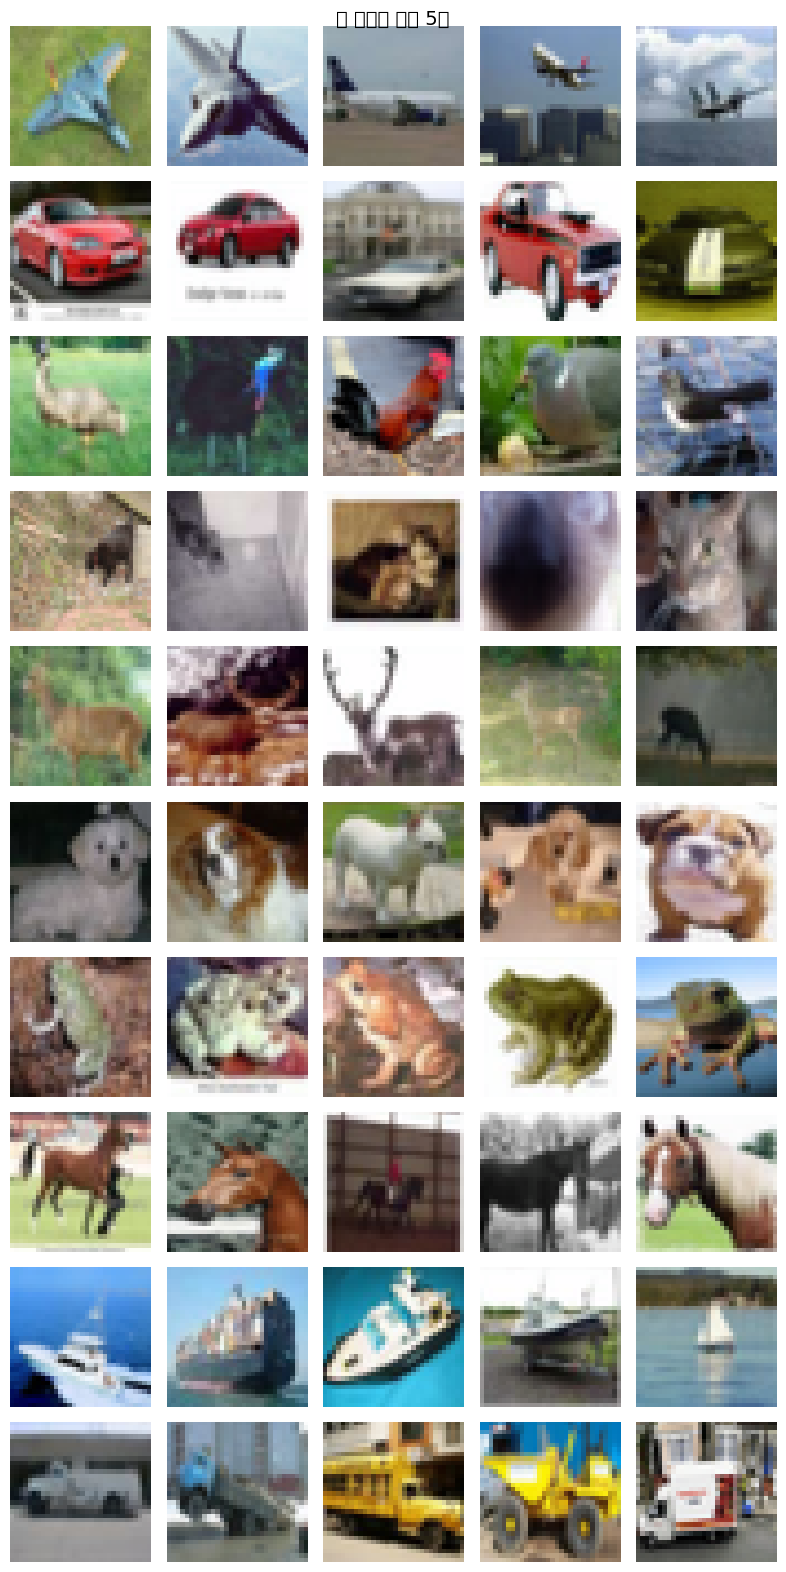

In [3]:
# (1) ÌÅ¥ÎûòÏä§Î≥Ñ ÏÉòÌîå 5Ïû•Ïî© ÏãúÍ∞ÅÌôî
import math
fig, axes = plt.subplots(10, 5, figsize=(8,16))
counts = {c:0 for c in class_names}
for x,y in train_loader:
    for img, lab in zip(x, y):
        c = class_names[lab.item()]
        if counts[c] < 5:
            ax = axes[class_names.index(c), counts[c]]
            ax.imshow(denorm(img)); ax.set_axis_off()
            if counts[c]==0: ax.set_ylabel(c, rotation=0, labelpad=30, va='center')
            counts[c]+=1
    if all(counts[c]>=5 for c in class_names): break
plt.suptitle('Í∞Å ÌÅ¥ÎûòÏä§ ÏÉòÌîå 5Ïû•', fontsize=14); plt.tight_layout(); plt.show()

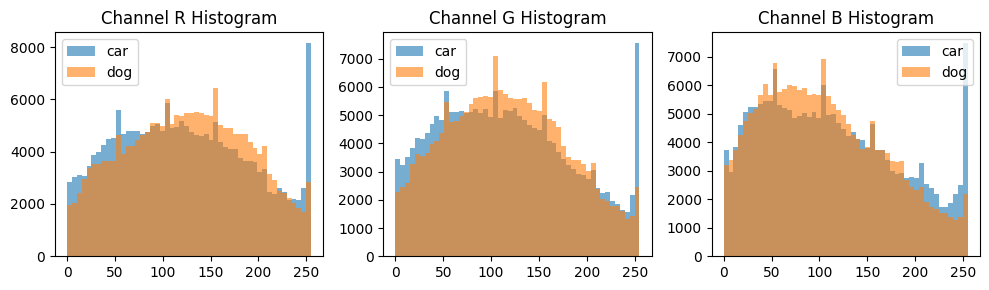

cars array: (200, 32, 32, 3) dogs array: (200, 32, 32, 3)


In [4]:
# (2) ÏûêÎèôÏ∞® vs Í∞ú RGB Ï±ÑÎÑêÎ≥Ñ ÌûàÏä§ÌÜ†Í∑∏Îû® ÎπÑÍµê
from torchvision.datasets import CIFAR10

raw_train = CIFAR10(root='./data', train=True, download=False)  # PIL Ïù¥ÎØ∏ÏßÄ Ï†ëÍ∑ºÏö©
def collect_pixels(label_name, max_imgs=200):
    idx_label = class_names.index(label_name)
    vals = []
    cnt = 0
    for img, lab in raw_train:
        if lab == idx_label:
            vals.append(np.array(img))  # (H,W,3), 0~255
            cnt += 1
            if cnt>=max_imgs: break
    arr = np.stack(vals, axis=0)  # (N,H,W,3)
    return arr

cars = collect_pixels('automobile', max_imgs=200)
dogs = collect_pixels('dog', max_imgs=200)

plt.figure(figsize=(10,3))
for i, ch in enumerate(['R','G','B']):
    plt.subplot(1,3,i+1)
    plt.hist(cars[:,:,:,i].ravel(), bins=50, alpha=0.6, label='car')
    plt.hist(dogs[:,:,:,i].ravel(), bins=50, alpha=0.6, label='dog')
    plt.title(f'Channel {ch} Histogram'); plt.legend()
plt.tight_layout(); plt.show()

print('cars array:', cars.shape, 'dogs array:', dogs.shape)

## 2. Baseline ÎπÑÍµê (‚âà6Î∂Ñ)

**ÎßêÌïòÍ∏∞ Ìè¨Ïù∏Ìä∏:**  
- MLPÎäî Í≥µÍ∞Ñ Ï†ïÎ≥¥Î•º ÌôúÏö©ÌïòÏßÄ Î™ªÌï® ‚Üí ÌååÎùºÎØ∏ÌÑ∞ Ïàò ÎåÄÎπÑ ÎπÑÌö®Ïú®Ï†Å.  
- CNNÏùÄ ÏßÄÏó≠(Ïª§ÎÑê) Îã®ÏúÑÎ°ú Í∞ÄÏ§ëÏπòÎ•º Í≥µÏú† ‚Üí Ìö®Ïú®ÏÑ±‚Üë, ÏùºÎ∞òÌôî‚Üë.

**ÏßàÎ¨∏:** ‚ÄúÍ∞ôÏùÄ ÌååÎùºÎØ∏ÌÑ∞ ÏàòÎùºÎ©¥ Ïñ¥Îñ§ Íµ¨Ï°∞Í∞Ä Îçî Ïú†Î¶¨Ìï†ÍπåÏöî?‚Äù


In [5]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32*32*3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.fc(self.flatten(x))

class CNN_V1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mlp = MLP().to(device)
cnn = CNN_V1().to(device)
print('MLP params:', count_params(mlp))
print('CNN_V1 params:', count_params(cnn))

MLP params: 789258
CNN_V1 params: 94538


In [6]:
def train_epoch(model, loader, loss_fn, optim_):
    model.train(); tl=0; tc=0; n=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optim_.zero_grad()
        out = model(x); loss = loss_fn(out,y)
        loss.backward(); optim_.step()
        tl += loss.item()*x.size(0)
        tc += (out.argmax(1)==y).sum().item(); n += x.size(0)
    return tl/n, tc/n

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval(); tl=0; tc=0; n=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x); loss = loss_fn(out,y)
        tl += loss.item()*x.size(0)
        tc += (out.argmax(1)==y).sum().item(); n += x.size(0)
    return tl/n, tc/n

In [7]:
criterion = nn.CrossEntropyLoss()
def train_model(model, epochs=5, lr=1e-3):
    optim_ = optim.Adam(model.parameters(), lr=lr)
    hist = {'train_acc':[], 'val_acc':[], 'train_loss':[], 'val_loss':[]}
    for ep in range(1, epochs+1):
        tr_l, tr_a = train_epoch(model, train_loader, criterion, optim_)
        va_l, va_a = eval_epoch(model, val_loader, criterion)
        hist['train_loss'].append(tr_l); hist['val_loss'].append(va_l)
        hist['train_acc'].append(tr_a);  hist['val_acc'].append(va_a)
        print(f'[Ep {ep}/{epochs}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')
    return hist

mlp_hist = train_model(mlp, epochs=5)
cnn_hist = train_model(cnn, epochs=10)  # CNNÏùÄ Ï°∞Í∏à Îçî ÌïôÏäµ

[Ep 1/5] train=0.380/1.805  val=0.455/1.559
[Ep 2/5] train=0.443/1.594  val=0.482/1.493
[Ep 3/5] train=0.464/1.539  val=0.485/1.479
[Ep 4/5] train=0.475/1.500  val=0.477/1.487
[Ep 5/5] train=0.494/1.463  val=0.496/1.462
[Ep 1/10] train=0.298/1.861  val=0.394/1.637
[Ep 2/10] train=0.422/1.571  val=0.487/1.436
[Ep 3/10] train=0.478/1.439  val=0.525/1.352
[Ep 4/10] train=0.508/1.361  val=0.537/1.296
[Ep 5/10] train=0.531/1.301  val=0.579/1.205
[Ep 6/10] train=0.554/1.253  val=0.587/1.169
[Ep 7/10] train=0.569/1.212  val=0.609/1.125
[Ep 8/10] train=0.585/1.166  val=0.610/1.102
[Ep 9/10] train=0.599/1.133  val=0.630/1.056
[Ep 10/10] train=0.609/1.107  val=0.641/1.022


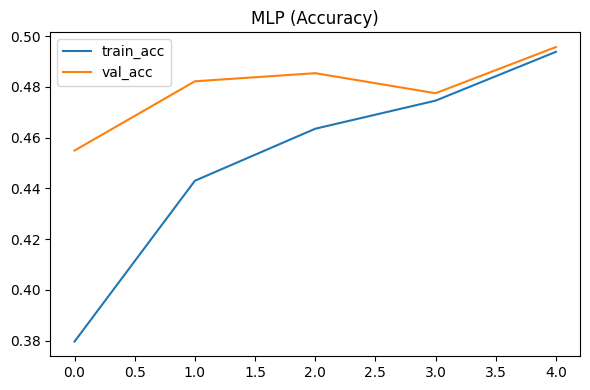

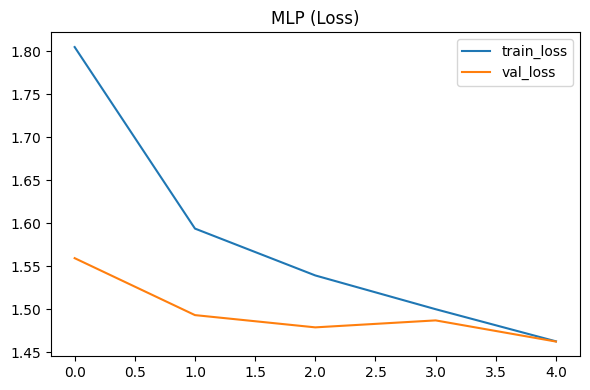

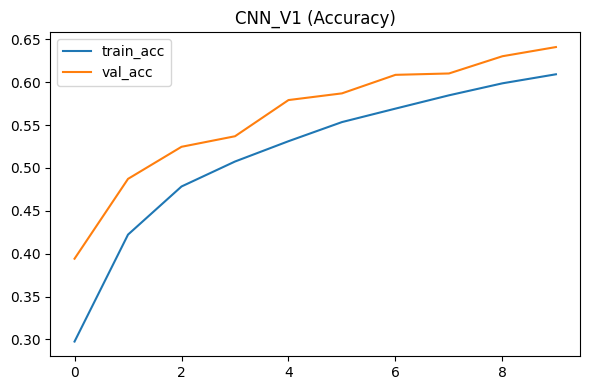

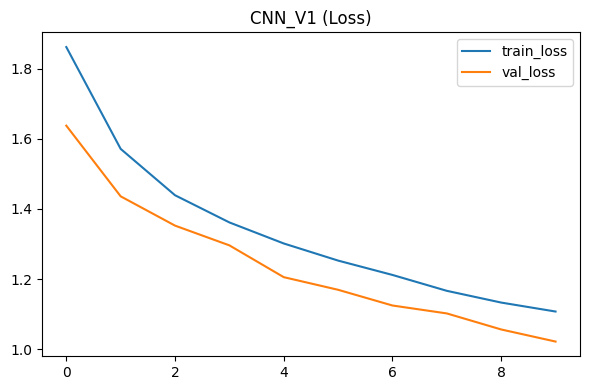

In [8]:
# ÌïôÏäµÍ≥°ÏÑ† ÎÇòÎûÄÌûà ÌîåÎ°Ø
def plot_hist(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h['train_acc'], label='train_acc')
    plt.plot(h['val_acc'], label='val_acc')
    plt.title(title+'(Accuracy)'); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,4))
    plt.plot(h['train_loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title(title+'(Loss)'); plt.legend(); plt.tight_layout(); plt.show()

plot_hist(mlp_hist, 'MLP ')
plot_hist(cnn_hist, 'CNN_V1 ')

## 3. CNN ÎÇ¥Î∂Ä ÏãúÍ∞ÅÌôî (‚âà5Î∂Ñ)

**ÎßêÌïòÍ∏∞ Ìè¨Ïù∏Ìä∏:**  
- Ï¥àÍ∏∞ ÌïÑÌÑ∞Îäî Ïó£ÏßÄ/ÏÉâÏÉÅ Í∞ôÏùÄ Ï†ÄÏàòÏ§Ä ÌäπÏßïÏùÑ ÎΩëÏäµÎãàÎã§.  
- Ïù¥ÌõÑ Î†àÏù¥Ïñ¥Î°ú Í∞àÏàòÎ°ù Ìå®ÌÑ¥/ÌòïÌÉú Í∞ôÏùÄ Í≥†ÏàòÏ§Ä ÌäπÏßïÏúºÎ°ú Ïù¥Ïñ¥ÏßëÎãàÎã§.


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  plt.suptitle('Ï≤´ Conv ÌïÑÌÑ∞(ÌèâÍ∑† Ï±ÑÎÑê)'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  plt.suptitle('Ï≤´ Conv ÌïÑÌÑ∞(ÌèâÍ∑† Ï±ÑÎÑê)'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.suptitle('Ï≤´ Conv ÌïÑÌÑ∞(ÌèâÍ∑† Ï±ÑÎÑê)'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1156136407.py:16: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.suptitle('Ï≤´ Conv ÌïÑÌÑ∞(ÌèâÍ∑† Ï±ÑÎÑê)'); plt.tight_layout(); plt.show()
/var

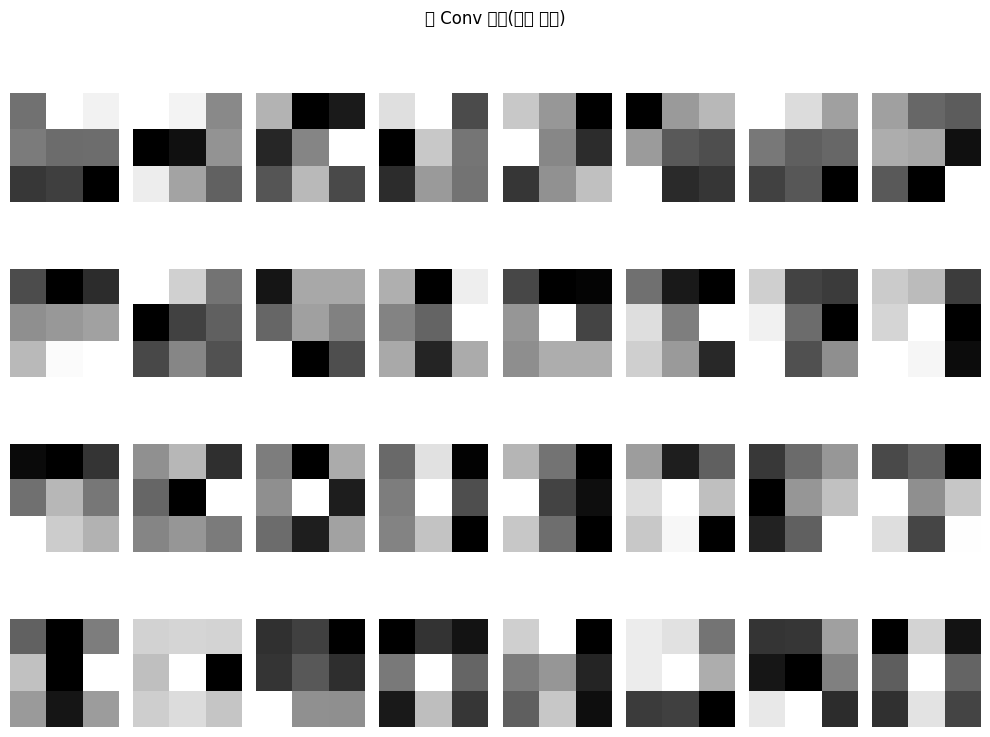

In [9]:
# (1) Ï≤´ Conv Î†àÏù¥Ïñ¥ ÌïÑÌÑ∞ Í∞ÄÏ§ëÏπò ÏãúÍ∞ÅÌôî
w = cnn.features[0].weight.data.cpu()  # (out, in, k, k)
w_min, w_max = w.min().item(), w.max().item()
grid = []
for i in range(min(32, w.shape[0])):  # 32Í∞úÍπåÏßÄÎßå
    filt = w[i]
    # Ï±ÑÎÑê ÌèâÍ∑†ÏúºÎ°ú 2D Îßµ ÎßåÎì§Í∏∞
    fmap = filt.mean(0)
    grid.append((fmap - w_min)/(w_max - w_min + 1e-9))
grid = torch.stack(grid,0).numpy()

cols = 8; rows = (len(grid)+cols-1)//cols
plt.figure(figsize=(10, 2*rows))
for i, g in enumerate(grid):
    plt.subplot(rows, cols, i+1); plt.imshow(g, cmap='gray'); plt.axis('off')
plt.suptitle('Ï≤´ Conv ÌïÑÌÑ∞(ÌèâÍ∑† Ï±ÑÎÑê)'); plt.tight_layout(); plt.show()

/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/1649260289.py:10: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  plt.suptitle('Ï≤´ Conv Feature Maps'); plt.tight_layout(); plt.show()


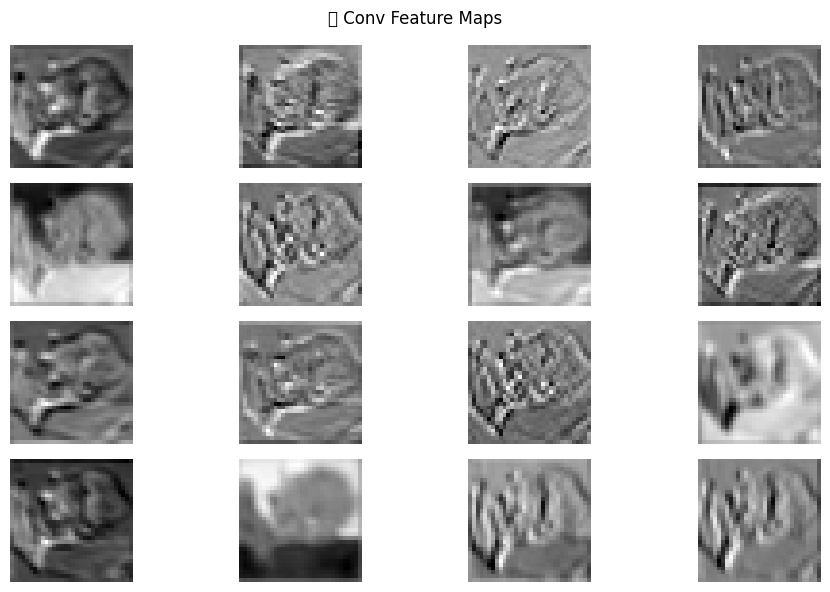

In [10]:
# (2) ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ 1Ïû•Ïùò Ï≤´ Conv ÌäπÏßïÎßµ
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x[0:1].to(device)
    features = cnn.features[0](x)  # Ï≤´ Conv Í≤∞Í≥º (N=1, C=32, H, W)
plt.figure(figsize=(10,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(features[0,i].cpu(), cmap='gray'); plt.axis('off')
plt.suptitle('Ï≤´ Conv Feature Maps'); plt.tight_layout(); plt.show()

## 4. Ïò§Î∂ÑÎ•ò Î∂ÑÏÑù Ïã¨Ìôî (‚âà5Î∂Ñ)

**ÎßêÌïòÍ∏∞ Ìè¨Ïù∏Ìä∏:**  
- Confusion MatrixÎ°ú **ÏûêÏ£º Ìó∑Í∞àÎ¶¨Îäî ÌÅ¥ÎûòÏä§ Ïåç**ÏùÑ Ï∞æÏäµÎãàÎã§.  
- Ìï¥Îãπ ÏåçÏùò ÏÉòÌîåÏùÑ Ïó¨Îü¨ Ïû• Î≥¥Ïó¨Ï£ºÎ©∞, Í≥µÌÜµ Ìå®ÌÑ¥ÏùÑ ÌÜ†Î°†Ìï©ÎãàÎã§.


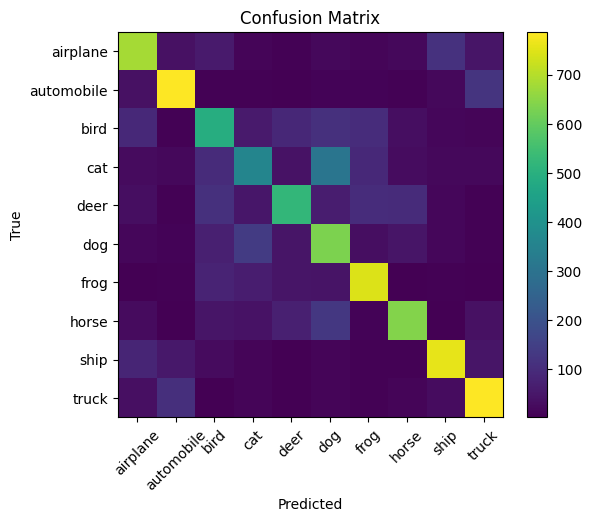

Top-3 ÌòºÎèô ÌÅ¥ÎûòÏä§ Ïåç: [('cat', 'dog', 307), ('dog', 'cat', 137), ('horse', 'dog', 127)]


/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'ÌòºÎèô ÏÇ¨Î°Ä: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'ÌòºÎèô ÏÇ¨Î°Ä: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'ÌòºÎèô ÏÇ¨Î°Ä: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()
/var/folders/48/477vrv_n08b185fbd1ycjrqh0000gn/T/ipykernel_4118/3837015562.py:55: UserWarning: Glyph 47168 (\N{HANGUL SYLLABLE RYE}) missing from font(s) DejaVu Sans.
  plt.suptitle(f'ÌòºÎèô

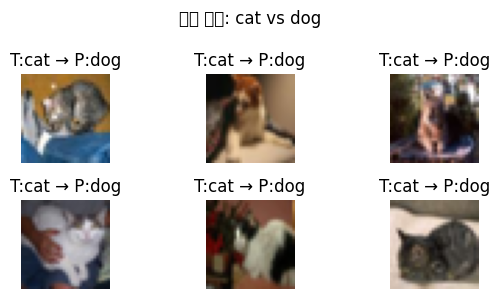

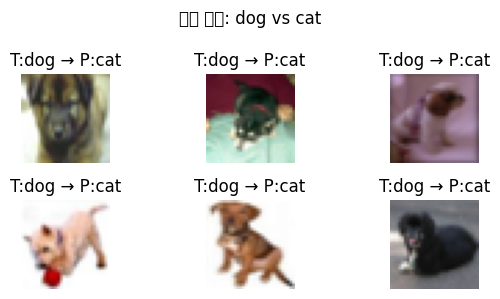

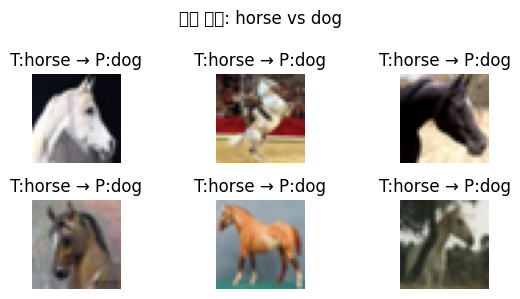

In [11]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval(); ys=[]; ps=[]
    for x,y in loader:
        x = x.to(device); out = model(x)
        ps.append(out.argmax(1).cpu().numpy()); ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(ps)

y_true, y_pred = get_all_preds(cnn, test_loader)

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix')
plt.colorbar(); plt.xticks(range(10), class_names, rotation=45); plt.yticks(range(10), class_names)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# Top-3 ÌòºÎèô ÌÅ¥ÎûòÏä§ Ïåç Ï∂îÏ∂ú
pairs = []
for i in range(10):
    for j in range(10):
        if i!=j and cm[i,j]>0:
            pairs.append(((i,j), cm[i,j]))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]
print('Top-3 ÌòºÎèô ÌÅ¥ÎûòÏä§ Ïåç:', [(class_names[i], class_names[j], n) for (i,j), n in pairs])

# Í∞Å ÏåçÏóêÏÑú Ïò§Î∂ÑÎ•ò ÏÉòÌîå 6Ïû• ÌëúÏãú
raw_test = datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.ToTensor())
idx_map = list(range(len(raw_test)))  # ÏõêÎ≥∏ Ïù∏Îç±Ïä§ Ï†ëÍ∑ºÏö©
# test_loader ÏàúÏÑúÏôÄ raw_test Ïù∏Îç±Ïä§Îäî Îã§Î•º Ïàò ÏûàÏúºÎØÄÎ°ú, ÎùºÎ≤® Í∏∞Î∞òÏúºÎ°ú Ïä§Ï∫î
def find_mismatch_indices(true_label, pred_label, max_show=6):
    out_idx = []
    count = 0
    # brute-force: Ï†ÑÏ≤¥ ÏòàÏ∏°ÏùÑ Îã§Ïãú ÏàúÏ∞®Î°ú ÌôïÏù∏
    ptr = 0
    for batch_x, batch_y in DataLoader(test_set, batch_size=128, shuffle=False):
        with torch.no_grad():
            logits = cnn(batch_x.to(device))
            preds = logits.argmax(1).cpu().numpy()
        for k in range(len(batch_y)):
            if batch_y[k].item()==true_label and preds[k]==pred_label:
                out_idx.append(ptr+k)
                count += 1
                if count>=max_show: return out_idx
        ptr += len(batch_y)
    return out_idx

for (i,j), _ in pairs:
    ids = find_mismatch_indices(i,j, max_show=6)
    if not ids: continue
    plt.figure(figsize=(6,3))
    for k, idx in enumerate(ids):
        img,_ = raw_test[idx]
        plt.subplot(2,3,k+1); plt.imshow(img.permute(1,2,0)); plt.axis('off')
        plt.title(f'T:{class_names[i]} ‚Üí P:{class_names[j]}')
    plt.suptitle(f'ÌòºÎèô ÏÇ¨Î°Ä: {class_names[i]} vs {class_names[j]}'); plt.tight_layout(); plt.show()

## 5. ÏÑ±Îä• Í∞úÏÑ† Í∏∞Î≤ï (‚âà6Î∂Ñ)

**ÎßêÌïòÍ∏∞ Ìè¨Ïù∏Ìä∏:**  
- Ï¶ùÍ∞ï, Ï†ïÍ∑úÌôî, ÎìúÎ°≠ÏïÑÏõÉ/Î∞∞ÏπòÏ†ïÍ∑úÌôî, ÏòµÌã∞ÎßàÏù¥Ï†Ä Î≥ÄÍ≤Ω Îì±ÏúºÎ°ú Í≥ºÏ†ÅÌï©ÏùÑ Ï†úÏñ¥ÌïòÍ≥† ÏùºÎ∞òÌôîÎ•º Í∞úÏÑ†Ìï©ÎãàÎã§.


[CNN_V2][SGD][Ep 1] train=0.313/1.802  val=0.355/1.777
[CNN_V2][SGD][Ep 2] train=0.454/1.468  val=0.519/1.322
[CNN_V2][SGD][Ep 3] train=0.520/1.312  val=0.516/1.318
[CNN_V2][SGD][Ep 4] train=0.558/1.220  val=0.483/1.488
[CNN_V2][SGD][Ep 5] train=0.585/1.150  val=0.555/1.215
[CNN_V2][SGD][Ep 6] train=0.605/1.100  val=0.613/1.086
[CNN_V2][SGD][Ep 7] train=0.622/1.052  val=0.603/1.088
[CNN_V2][SGD][Ep 8] train=0.631/1.020  val=0.648/0.981
[CNN_V2][SGD][Ep 9] train=0.650/0.984  val=0.651/0.974
[CNN_V2][SGD][Ep 10] train=0.655/0.966  val=0.658/0.979
[CNN_V2][SGD][Ep 11] train=0.667/0.933  val=0.685/0.873


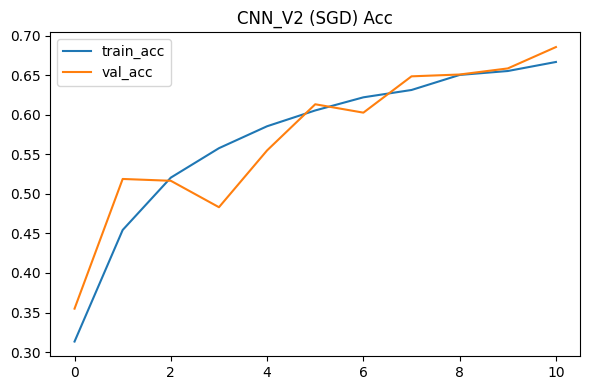

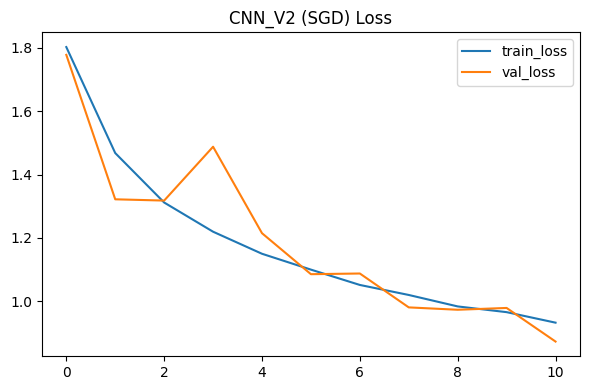

In [12]:
# Ï¶ùÍ∞ï ÌååÏù¥ÌîÑÎùºÏù∏Í≥º BN/DropoutÏùÑ Ìè¨Ìï®Ìïú Í∞úÏÑ† Î™®Îç∏
aug_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
])
train_full_aug = datasets.CIFAR10(root='./data', train=True, download=False, transform=aug_tf)
train_set2, val_set2 = random_split(train_full_aug, [train_len, val_len])
train_loader2=DataLoader(train_set2,batch_size=128,shuffle=True,num_workers=0)
val_loader2  =DataLoader(val_set2,  batch_size=128,shuffle=False,num_workers=0)

class CNN_V2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
    def forward(self,x): return self.net(x)

cnn2 = CNN_V2().to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer Ïã§Ìóò: SGD vs Adam
opt_name = 'SGD'  # 'Adam'ÏúºÎ°ú Î≥ÄÍ≤ΩÌïòÏó¨ ÎπÑÍµê Ïã§Ìóò
optimizer = optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9) if opt_name=='SGD' else optim.Adam(cnn2.parameters(), lr=1e-3)

hist2={'train_acc':[],'val_acc':[],'train_loss':[],'val_loss':[]}
for ep in range(1, 12):  # ÏïΩÍ∞Ñ Îçî ÌïôÏäµ
    tr_l,tr_a = train_epoch(cnn2, train_loader2, criterion, optimizer)
    va_l,va_a = eval_epoch(cnn2, val_loader2, criterion)
    hist2['train_loss'].append(tr_l); hist2['val_loss'].append(va_l)
    hist2['train_acc'].append(tr_a);  hist2['val_acc'].append(va_a)
    print(f'[CNN_V2][{opt_name}][Ep {ep}] train={tr_a:.3f}/{tr_l:.3f}  val={va_a:.3f}/{va_l:.3f}')

# ÏÑ±Îä• ÎπÑÍµê
def plot_hist(h, title):
    plt.figure(figsize=(6,4)); plt.plot(h['train_acc'],label='train_acc'); plt.plot(h['val_acc'],label='val_acc'); plt.title(title+' Acc'); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,4)); plt.plot(h['train_loss'],label='train_loss'); plt.plot(h['val_loss'],label='val_loss'); plt.title(title+' Loss'); plt.legend(); plt.tight_layout(); plt.show()

plot_hist(hist2, f'CNN_V2 ({opt_name})')

## 6. Ïã§Ïäµ Ï±åÎ¶∞ÏßÄ (‚âà2Î∂Ñ)

- **Î†àÏù¥Ïñ¥ Ïàò ÎäòÎ¶¨Í∏∞**: Conv Î∏îÎ°ù Ï∂îÍ∞Ä ÌõÑ ÏÑ±Îä•/ÏãúÍ∞Ñ Î≥ÄÌôî ÎπÑÍµê  
- **Ï¶ùÍ∞ï Í∞ïÎèÑ Ï°∞Ï†à**: `ColorJitter`, `RandomErasing` Îì± Ï∂îÍ∞ÄÌïòÏó¨ ÏùºÎ∞òÌôî ÌôïÏù∏  
- **Optimizer ÍµêÏ≤¥**: SGD ‚Üî Adam, ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨(`StepLR`, `CosineAnnealingLR`) ÎèÑÏûÖ
